In [1]:
!pip install -q sentence-transformers bertopic optuna

In [2]:
import pandas as pd
import numpy as np
import hdbscan
import optuna

import matplotlib.pyplot as plt
from tqdm import tqdm

from umap import UMAP
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")

# Конфигурация pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
data = {
    'review_title': [
        'Отличный банк', 'Хорошее обслуживание', 'Высокие комиссии', 'Неудобное приложение',
        'Отличные кредиты', 'Медленное обслуживание', 'Хорошая поддержка',
        'Высокие проценты', 'Плохой сервис', 'Удобный интерфейс'
        ],
    'review_text': [
        'Обслуживание на высшем уровне.        ',
        'Персонал вежливый, но ожидание было долгим -------',
        'Комиссии за услуги слишком высокие!!!!!!',
        'Приложение неудобное, сложно найти нужные функции',
        'Низкие проценты по кредитам, гибкие условия',
        'Обслуживание очень медленное, постоянно очереди',
        'Поддержка клиентов решает вопросы быстро и эффективно',
        'Проценты по кредитам слишком высокие, не рекомендую',
        'Сервис оставляет желать лучшего, много ошибок и проблем',
        'Интерфейс приложения очень удобный, все легко найти'
    ]
}

df = pd.DataFrame(data)


df['all_text'] = df['review_title'] + " " + df['review_text']
texts = df['all_text'].tolist()

df

,review_title,review_text,all_text
0,Отличный банк,Обслуживание на высшем уровне.,Отличный банк Обслуживание на высшем уровне.
1,Хорошее обслуживание,"Персонал вежливый, но ожидание было долгим -------","Хорошее обслуживание Персонал вежливый, но ожидание было долгим -------"
2,Высокие комиссии,Комиссии за услуги слишком высокие!!!!!!,Высокие комиссии Комиссии за услуги слишком высокие!!!!!!
3,Неудобное приложение,"Приложение неудобное, сложно найти нужные функции","Неудобное приложение Приложение неудобное, сложно найти нужные функции"
4,Отличные кредиты,"Низкие проценты по кредитам, гибкие условия","Отличные кредиты Низкие проценты по кредитам, гибкие условия"
5,Медленное обслуживание,"Обслуживание очень медленное, постоянно очереди","Медленное обслуживание Обслуживание очень медленное, постоянно очереди"
6,Хорошая поддержка,Поддержка клиентов решает вопросы быстро и эффективно,Хорошая поддержка Поддержка клиентов решает вопросы быстро и эффективно
7,Высокие проценты,"Проценты по кредитам слишком высокие, не рекомендую","Высокие проценты Проценты по кредитам слишком высокие, не рекомендую"
8,Плохой сервис,"Сервис оставляет желать лучшего, много ошибок и проблем","Плохой сервис Сервис оставляет желать лучшего, много ошибок и проблем"
9,Удобный интерфейс,"Интерфейс приложения очень удобный, все легко найти","Удобный интерфейс Интерфейс приложения очень удобный, все легко найти"


Запускаем обучение модели

In [4]:
# эмбеддинги
embedding_model = SentenceTransformer('sergeyzh/LaBSE-ru-turbo')

# уменьшение размерности из 768 в 8
umap_model = UMAP(n_neighbors=10, n_components=8, min_dist=0.1, random_state=42)#, metric='cosine')

# кластеризатор
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

# BERTopic с кастомными эмбеддингами и UMAP
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(texts)

In [5]:
topics

[0, 0, 1, 2, 1, 0, 0, 1, 0, 2]

In [6]:
probs

array([1.        , 1.        , 1.        , 1.        , 0.94227238,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Визуализируем топ-5 слов для каждой темы

In [7]:
topic_model.visualize_barchart()

In [8]:
df['clusters'] = topics

df[['review_title', 'review_text', 'clusters']]

,review_title,review_text,clusters
0,Отличный банк,Обслуживание на высшем уровне.,0
1,Хорошее обслуживание,"Персонал вежливый, но ожидание было долгим -------",0
2,Высокие комиссии,Комиссии за услуги слишком высокие!!!!!!,1
3,Неудобное приложение,"Приложение неудобное, сложно найти нужные функции",2
4,Отличные кредиты,"Низкие проценты по кредитам, гибкие условия",1
5,Медленное обслуживание,"Обслуживание очень медленное, постоянно очереди",0
6,Хорошая поддержка,Поддержка клиентов решает вопросы быстро и эффективно,0
7,Высокие проценты,"Проценты по кредитам слишком высокие, не рекомендую",1
8,Плохой сервис,"Сервис оставляет желать лучшего, много ошибок и проблем",0
9,Удобный интерфейс,"Интерфейс приложения очень удобный, все легко найти",2


В целом разделение очень логичное:
- 0: Обслуживание
- 1: Кредиты/Комиссии
- 2: Приложение

Визуализируем кластера в двухмерном пространстве

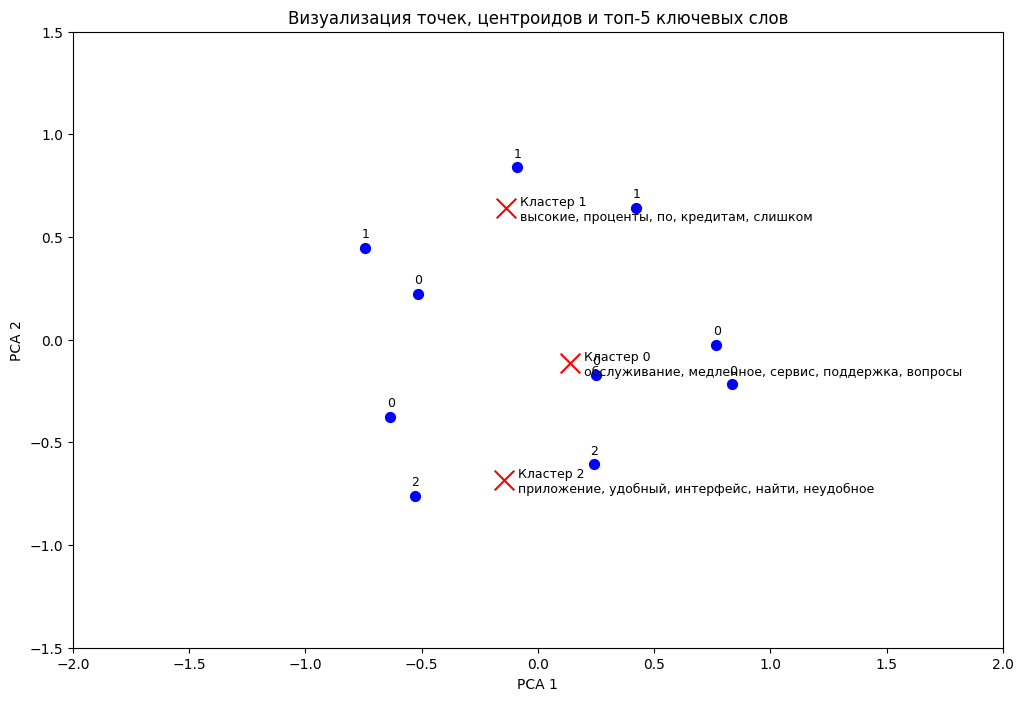

In [9]:
def vizualization_clusters(topic_model, df):

  # Уменьшаем размерность до 2D с помощью PCA
  pca_model = PCA(n_components=2)
  pca_embeddings = pca_model.fit_transform(topic_model.umap_model.embedding_)

  plt.figure(figsize=(12, 8))

  # Визуализируем кластеры
  for i, cluster in enumerate(df['clusters']):
      plt.scatter(pca_embeddings[i, 0], pca_embeddings[i, 1], color='blue', s=50)
      plt.text(pca_embeddings[i, 0]-0.015, pca_embeddings[i, 1]+0.05, str(cluster), fontsize=9)

  # Вычисляем центроиды для каждого кластера
  unique_topics = np.unique(df['clusters'])
  centroids = np.array([pca_embeddings[df['clusters'] == un_topic].mean(axis=0) for un_topic in unique_topics])

  # Получаем топ-5 слов для каждой темы
  top_n_words = 5
  topics_info = topic_model.get_topics()
  topic_keywords = {topic: [word for word, _ in topics_info[topic][:top_n_words]] for topic in topics_info.keys()}

  # Визуализируем кластеры
  plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=200)

  for i, centroid in enumerate(centroids):
      top_words = ', '.join(topic_keywords[unique_topics[i]])
      label_text = f'Кластер {unique_topics[i]}\n{top_words}'
      plt.text(centroid[0]+0.06, centroid[1]-0.06, label_text, fontsize=9, color='black')

  plt.title("Визуализация точек, центроидов и топ-5 ключевых слов")
  plt.xlabel("PCA 1")
  plt.ylabel("PCA 2")
  plt.xlim([-2, 2])
  plt.ylim([-1.5, 1.5]);


vizualization_clusters(topic_model, df)

Посмотрим на метрики

In [10]:
umap_embeddings = topic_model.umap_model.embedding_

silhouette_avg = silhouette_score(umap_embeddings, topics)
calinski_harabasz = calinski_harabasz_score(umap_embeddings, topics)
davies_bouldin = davies_bouldin_score(umap_embeddings, topics)

comparison_table = pd.DataFrame({
    "Метрика": ["Силуэтный коэффициент", "Calinski-Harabasz Index", "Davis-Bouldin Index"],
    "Диапазон значений": ["-1, 1", "-", "-"],
    "Описание": ["0-плохо, чем ближе к 1, тем лучше", "чем больше, тем лучше", "чем меньше значений, тем лучше. меньше 1 вообще супер"],
    "Значение": [silhouette_avg, calinski_harabasz, davies_bouldin]
    })

comparison_table

,Метрика,Диапазон значений,Описание,Значение
0,Силуэтный коэффициент,"-1, 1","0-плохо, чем ближе к 1, тем лучше",0.202663
1,Calinski-Harabasz Index,-,"чем больше, тем лучше",3.027000
2,Davis-Bouldin Index,-,"чем меньше значений, тем лучше. меньше 1 вообще супер",1.229242


Предыдущие параметры UMAP были выбраны вручную, теперь оптимизируем процесс и подберем параметры через Optuna.

Будем выбирать лучшу модель на основе силуэтного коэффициента

In [11]:
def custom_metric(embedding_model_name, umap_model, hdbscan_model, texts):

  embedding_model = SentenceTransformer(embedding_model_name)
  topic_model = BERTopic(embedding_model=embedding_model,
                         umap_model=umap_model,
                         hdbscan_model=hdbscan_model)
  topics, probs = topic_model.fit_transform(texts)

  # тут важно взять именно эмбеддинги после umap, те, что подаются на hdbscsan
  umap_embeddings = topic_model.umap_model.embedding_

  unique_topics = len(set(topics))
  if unique_topics < 2:
    return 'Кластеров меньше 2!'

  score = silhouette_score(umap_embeddings, topics)
  print(f"Индекс для модели {embedding_model_name} = {score}", )

  return score


def objective(trial):

  # модель для cоздания эмбеддингов
  embedding_model_name = trial.suggest_categorical(
      "embedding_model", [
          'cointegrated/rubert-tiny2',
          'sergeyzh/rubert-tiny-turbo',
          'cointegrated/LaBSE-en-ru',
          'sergeyzh/LaBSE-ru-sts',
          'sergeyzh/LaBSE-ru-turbo'])

  # UMAP
  n_neighbors = trial.suggest_int('n_neighbors', 2, 11)
  n_components = trial.suggest_int('n_components', 3, 8)
  min_dist = trial.suggest_float("min_dist", 0, 0.99)

  # инициализация UMAP модели
  umap_model = UMAP(n_neighbors=n_neighbors,
                    n_components=n_components,
                    min_dist=min_dist,
                    random_state=42)

  # HDBSCAN
  min_cluster_size = trial.suggest_int("min_cluster_size", 2, 8)
  min_samples = trial.suggest_int("min_samples", 1, 3)

  # инициализация HDBSCAN модели
  hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                  min_samples=min_samples)

  # вычисление кастомной метрики
  score = custom_metric(embedding_model_name, umap_model, hdbscan_model, texts)

  return score


# Запуск оптимизации (максимизация для силуэтного коэффициента)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

best_value = study.best_value
best_params = study.best_params

print()
print("Лучшие параметры:", best_params)
print("Index =", best_value)

[I 2025-03-19 11:49:13,649] A new study created in memory with name: no-name-0e036e57-1d71-422a-80ba-0ed4e628bf6e
[I 2025-03-19 11:49:16,547] Trial 0 finished with value: 0.05045668035745621 and parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-sts', 'n_neighbors': 9, 'n_components': 7, 'min_dist': 0.39665084207480245, 'min_cluster_size': 3, 'min_samples': 2}. Best is trial 0 with value: 0.05045668035745621.


Индекс для модели sergeyzh/LaBSE-ru-sts = 0.05045668035745621


[W 2025-03-19 11:49:20,466] Trial 1 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-sts', 'n_neighbors': 6, 'n_components': 6, 'min_dist': 0.26599018392503, 'min_cluster_size': 5, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:20,467] Trial 1 failed with value 'Кластеров меньше 2!'.
[I 2025-03-19 11:49:24,425] Trial 2 finished with value: 0.30308133363723755 and parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 10, 'n_components': 6, 'min_dist': 0.016129067650845985, 'min_cluster_size': 3, 'min_samples': 1}. Best is trial 2 with value: 0.30308133363723755.


Индекс для модели sergeyzh/rubert-tiny-turbo = 0.30308133363723755


[W 2025-03-19 11:49:27,472] Trial 3 failed with parameters: {'embedding_model': 'cointegrated/LaBSE-en-ru', 'n_neighbors': 3, 'n_components': 7, 'min_dist': 0.17932919376351777, 'min_cluster_size': 5, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:27,473] Trial 3 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:49:32,011] Trial 4 failed with parameters: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 3, 'n_components': 8, 'min_dist': 0.7372230372443871, 'min_cluster_size': 5, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:32,014] Trial 4 failed with value 'Кластеров меньше 2!'.
[I 2025-03-19 11:49:34,724] Trial 5 finished with value: 0.2289319783449173 and parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 6, 'n_components': 8, 'min_dist': 0.8136902986122626, 'min_cluster_size': 3, 'min_samples': 1}. Best is

Индекс для модели sergeyzh/rubert-tiny-turbo = 0.2289319783449173


[W 2025-03-19 11:49:37,295] Trial 6 failed with parameters: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 3, 'n_components': 7, 'min_dist': 0.9726349281197151, 'min_cluster_size': 7, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:37,295] Trial 6 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:49:39,960] Trial 7 failed with parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 8, 'n_components': 4, 'min_dist': 0.7914193029925171, 'min_cluster_size': 6, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:39,960] Trial 7 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:49:42,562] Trial 8 failed with parameters: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 5, 'n_components': 5, 'min_dist': 0.8700661993050881, 'min_cluster_size': 4, 'min_samples': 3} because of the following error: The valu

Индекс для модели cointegrated/rubert-tiny2 = 0.5246371626853943


[W 2025-03-19 11:49:52,899] Trial 11 failed with parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 10, 'n_components': 6, 'min_dist': 0.36653984654543376, 'min_cluster_size': 4, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:52,899] Trial 11 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:49:55,688] Trial 12 failed with parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 7, 'n_components': 8, 'min_dist': 0.36168449627801397, 'min_cluster_size': 5, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:49:55,689] Trial 12 failed with value 'Кластеров меньше 2!'.
[I 2025-03-19 11:49:58,792] Trial 13 finished with value: 0.20752111077308655 and parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 8, 'n_components': 5, 'min_dist': 0.8299216364614626, 'min_cluster_size': 3, 'min_samples': 

Индекс для модели sergeyzh/rubert-tiny-turbo = 0.20752111077308655


[W 2025-03-19 11:50:08,953] Trial 14 failed with parameters: {'embedding_model': 'cointegrated/LaBSE-en-ru', 'n_neighbors': 5, 'n_components': 5, 'min_dist': 0.4834462013117946, 'min_cluster_size': 7, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:50:08,954] Trial 14 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:50:13,904] Trial 15 failed with parameters: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 10, 'n_components': 5, 'min_dist': 0.733619551737122, 'min_cluster_size': 8, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:50:13,905] Trial 15 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:50:21,363] Trial 16 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-turbo', 'n_neighbors': 11, 'n_components': 5, 'min_dist': 0.5103570131137577, 'min_cluster_size': 8, 'min_samples': 3} because of the following error: The va

Индекс для модели sergeyzh/LaBSE-ru-turbo = 0.5904422998428345


[I 2025-03-19 11:50:34,970] Trial 20 finished with value: 0.10734273493289948 and parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 9, 'n_components': 6, 'min_dist': 0.6325890747549948, 'min_cluster_size': 4, 'min_samples': 2}. Best is trial 19 with value: 0.5904422998428345.


Индекс для модели sergeyzh/rubert-tiny-turbo = 0.10734273493289948


[W 2025-03-19 11:50:37,856] Trial 21 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-turbo', 'n_neighbors': 11, 'n_components': 4, 'min_dist': 0.48690241890886143, 'min_cluster_size': 7, 'min_samples': 1} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:50:37,857] Trial 21 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:50:40,678] Trial 22 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-turbo', 'n_neighbors': 3, 'n_components': 7, 'min_dist': 0.49222531453633767, 'min_cluster_size': 8, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:50:40,679] Trial 22 failed with value 'Кластеров меньше 2!'.
[I 2025-03-19 11:50:43,550] Trial 23 finished with value: 0.20963478088378906 and parameters: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 8, 'n_components': 7, 'min_dist': 0.878375209037899, 'min_cluster_size': 4, 'min_samples': 2}. Best

Индекс для модели cointegrated/rubert-tiny2 = 0.20963478088378906


[W 2025-03-19 11:50:46,529] Trial 24 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-turbo', 'n_neighbors': 4, 'n_components': 6, 'min_dist': 0.89358044436068, 'min_cluster_size': 8, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:50:46,530] Trial 24 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:50:49,518] Trial 25 failed with parameters: {'embedding_model': 'sergeyzh/rubert-tiny-turbo', 'n_neighbors': 4, 'n_components': 6, 'min_dist': 0.5539311509466838, 'min_cluster_size': 8, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:50:49,518] Trial 25 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:50:53,104] Trial 26 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-turbo', 'n_neighbors': 7, 'n_components': 6, 'min_dist': 0.7486652065223982, 'min_cluster_size': 7, 'min_samples': 2} because of the following error: The value

Индекс для модели cointegrated/rubert-tiny2 = 0.9473222494125366


[W 2025-03-19 11:51:03,396] Trial 29 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-sts', 'n_neighbors': 6, 'n_components': 7, 'min_dist': 0.09749125147430814, 'min_cluster_size': 2, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:51:03,396] Trial 29 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:51:06,093] Trial 30 failed with parameters: {'embedding_model': 'sergeyzh/LaBSE-ru-sts', 'n_neighbors': 3, 'n_components': 7, 'min_dist': 0.6593828227201133, 'min_cluster_size': 7, 'min_samples': 2} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:51:06,094] Trial 30 failed with value 'Кластеров меньше 2!'.
[I 2025-03-19 11:51:09,468] Trial 31 finished with value: 0.19715777039527893 and parameters: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 7, 'n_components': 3, 'min_dist': 0.6937818319203957, 'min_cluster_size': 2, 'min_samples': 1}. Best is t

Индекс для модели cointegrated/rubert-tiny2 = 0.19715777039527893


[W 2025-03-19 11:51:12,577] Trial 32 failed with parameters: {'embedding_model': 'cointegrated/LaBSE-en-ru', 'n_neighbors': 2, 'n_components': 3, 'min_dist': 0.29417540611402987, 'min_cluster_size': 7, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:51:12,578] Trial 32 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:51:25,867] Trial 33 failed with parameters: {'embedding_model': 'cointegrated/LaBSE-en-ru', 'n_neighbors': 2, 'n_components': 3, 'min_dist': 0.30729099874556776, 'min_cluster_size': 7, 'min_samples': 3} because of the following error: The value 'К' could not be cast to float.
[W 2025-03-19 11:51:25,868] Trial 33 failed with value 'Кластеров меньше 2!'.
[W 2025-03-19 11:51:28,850] Trial 34 failed with parameters: {'embedding_model': 'cointegrated/LaBSE-en-ru', 'n_neighbors': 2, 'n_components': 3, 'min_dist': 0.2732365258100463, 'min_cluster_size': 7, 'min_samples': 3} because of the following error: The v


Лучшие параметры: {'embedding_model': 'cointegrated/rubert-tiny2', 'n_neighbors': 2, 'n_components': 6, 'min_dist': 0.26455461101516475, 'min_cluster_size': 2, 'min_samples': 3}
Index = 0.9473222494125366


Запустим обучение на лучших параметрах, затем визуализируем

In [12]:
# Лучшие параметры:
# 'embedding_model': 'cointegrated/rubert-tiny2'
# 'n_neighbors': 2
# 'n_components': 6
# 'min_dist': 0.26455461101516475
# 'min_cluster_size': 2
# 'min_samples': 3}

# Index = 0.9473222494125366

embedding_model = SentenceTransformer('cointegrated/rubert-tiny2')
umap_model = UMAP(n_neighbors=2, n_components=6, min_dist=0.26455461101516475, random_state=42)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=3)
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(texts)

topic_model.visualize_barchart()

In [13]:
df['clusters'] = topics
display(df[['review_title', 'review_text', 'clusters']])

,review_title,review_text,clusters
0,Отличный банк,Обслуживание на высшем уровне.,0
1,Хорошее обслуживание,"Персонал вежливый, но ожидание было долгим -------",-1
2,Высокие комиссии,Комиссии за услуги слишком высокие!!!!!!,0
3,Неудобное приложение,"Приложение неудобное, сложно найти нужные функции",1
4,Отличные кредиты,"Низкие проценты по кредитам, гибкие условия",0
5,Медленное обслуживание,"Обслуживание очень медленное, постоянно очереди",-1
6,Хорошая поддержка,Поддержка клиентов решает вопросы быстро и эффективно,1
7,Высокие проценты,"Проценты по кредитам слишком высокие, не рекомендую",0
8,Плохой сервис,"Сервис оставляет желать лучшего, много ошибок и проблем",1
9,Удобный интерфейс,"Интерфейс приложения очень удобный, все легко найти",1


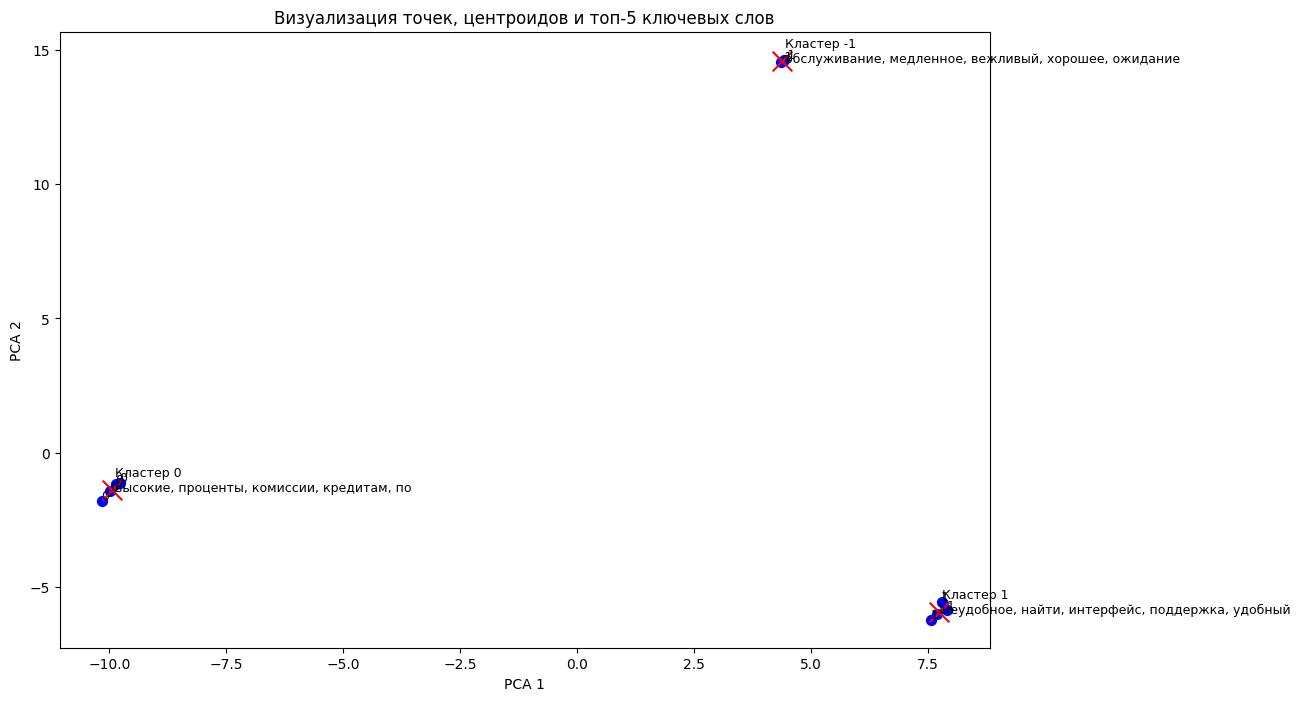

In [16]:
def vizualization_clusters(topic_model, df):

  # Уменьшаем размерность до 2D с помощью PCA
  pca_model = PCA(n_components=2)
  pca_embeddings = pca_model.fit_transform(topic_model.umap_model.embedding_)

  plt.figure(figsize=(12, 8))

  # Визуализируем кластеры
  for i, cluster in enumerate(df['clusters']):
      plt.scatter(pca_embeddings[i, 0], pca_embeddings[i, 1], color='blue', s=50)
      plt.text(pca_embeddings[i, 0]-0.015, pca_embeddings[i, 1]+0.05, str(cluster), fontsize=9)

  # Вычисляем центроиды для каждого кластера
  unique_topics = np.unique(df['clusters'])
  centroids = np.array([pca_embeddings[df['clusters'] == un_topic].mean(axis=0) for un_topic in unique_topics])

  # Получаем топ-5 слов для каждой темы
  top_n_words = 5
  topics_info = topic_model.get_topics()
  topic_keywords = {topic: [word for word, _ in topics_info[topic][:top_n_words]] for topic in topics_info.keys()}

  # Визуализируем кластеры
  plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=200)

  for i, centroid in enumerate(centroids):
      top_words = ', '.join(topic_keywords[unique_topics[i]])
      label_text = f'Кластер {unique_topics[i]}\n{top_words}'
      plt.text(centroid[0]+0.06, centroid[1]-0.06, label_text, fontsize=9, color='black')

  plt.title("Визуализация точек, центроидов и топ-5 ключевых слов")
  plt.xlabel("PCA 1")
  plt.ylabel("PCA 2")


vizualization_clusters(topic_model, df)

In [17]:
umap_embeddings = topic_model.umap_model.embedding_

silhouette_avg = silhouette_score(umap_embeddings, topics)
calinski_harabasz = calinski_harabasz_score(umap_embeddings, topics)
davies_bouldin = davies_bouldin_score(umap_embeddings, topics)

comparison_table = pd.DataFrame({
    "Метрика": ["Силуэтный коэффициент", "Calinski-Harabasz Index", "Davis-Bouldin Index"],
    "Диапазон значений": ["-1, 1", "-", "-"],
    "Описание": ["0-плохо, чем ближе к 1, тем лучше", "чем больше, тем лучше", "чем меньше значений, тем лучше. меньше 1 вообще супер"],
    "Значение": [silhouette_avg, calinski_harabasz, davies_bouldin]
    })

comparison_table

,Метрика,Диапазон значений,Описание,Значение
0,Силуэтный коэффициент,"-1, 1","0-плохо, чем ближе к 1, тем лучше",0.947322
1,Calinski-Harabasz Index,-,"чем больше, тем лучше",1035.413330
2,Davis-Bouldin Index,-,"чем меньше значений, тем лучше. меньше 1 вообще супер",0.064630
